# Setting working directory

## Load the Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## 查看内存容量
!free -m

              total        used        free      shared  buff/cache   available
Mem:          13021         528       10541           0        1951       12225
Swap:             0           0           0


In [4]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/XiamenIntlBank')
# !ls

## Change the workding dir to: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl'`

In [5]:
# os.makedirs("originalDataset")
# os.makedirs("preprocessedData")
# os.makedirs("submissionResults")

## Go to this place for original dataset: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl/originalDataset'`

In [ ]:
# ## unzip the data if necessary
# !unzip originalDataset/给选手数据.zip -d originalDataset

# Importing libraries

In [7]:
!pip install catboost

     |████████████████████████████████| 66.3MB 93kB/s 


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
# import tqdm
warnings.filterwarnings('ignore')

# EDA targets

* Month type data: `aum, cunkuan, behavior`
* Quarter type data: `big_event, cust_avli, cust_info`

看label的分布，多少个类别，每一个类别各占多少。

对object的和numerical的进行区分。

。。。。想到再说

# Starting EDA

## merge the table for a quater

In this example, for quarter 3 (month 7, 8, 9)

In [9]:
## shall we merge the quarter data first? 

In [10]:
def changeColName(df_origin, df_name):
    '''
    df_origin is data frame
    df_name is string, the name of the dataframe
    '''
    df = df_origin.copy()
    cols = df.columns
    newCols = []
    for col in cols:
        if col == "cust_no":
            newCol = col
        else:
            newCol = "{}_{}".format(df_name, col)
        newCols.append(newCol)
    df.columns = newCols
    return df

In [11]:
aum_m7 = pd.read_csv('originalDataset/x_test/aum_test/aum_m1.csv')
aum_m8 = pd.read_csv('originalDataset/x_test/aum_test/aum_m2.csv')
aum_m9 = pd.read_csv('originalDataset/x_test/aum_test/aum_m3.csv')

In [12]:
### 这里解释一下为什么要用1，2，3而非原本的月份数：这里表示的是季度内第一个，第二个和第三个月。
df3 = pd.merge(
    changeColName(aum_m7, "aum_m1"), changeColName(aum_m8, "aum_m2"), 
    how='outer',on='cust_no'
)

df3 = pd.merge(
    df3, changeColName(aum_m9, "aum_m3"), 
    how='outer',on='cust_no'
)

In [13]:
behavior_m7 = pd.read_csv('originalDataset/x_test/behavior_test/behavior_m1.csv')
behavior_m8 = pd.read_csv('originalDataset/x_test/behavior_test/behavior_m2.csv')
behavior_m9 = pd.read_csv('originalDataset/x_test/behavior_test/behavior_m3.csv')

In [14]:
df3 = pd.merge(
    df3, changeColName(behavior_m7, "behavior_m1"), 
    how='outer',on='cust_no'
)

df3 = pd.merge(
    df3, changeColName(behavior_m8, "behavior_m2"), 
    how='outer',on='cust_no'
)

df3 = pd.merge(
    df3, changeColName(behavior_m9, "behavior_m3"), 
    how='outer',on='cust_no'
)

In [15]:
big_event_q3 = pd.read_csv('originalDataset/x_test/big_event_test/big_event_Q1.csv')
# big_event_q4 = pd.read_csv('originalDataset/x_train/big_event_train/big_event_Q4.csv')

In [16]:
df3 = pd.merge(
    df3, changeColName(big_event_q3, "big_event"), 
    how='outer',on='cust_no'
)

In [17]:
cunkuan_m7 = pd.read_csv('originalDataset/x_test/cunkuan_test/cunkuan_m1.csv')
cunkuan_m8 = pd.read_csv('originalDataset/x_test/cunkuan_test/cunkuan_m2.csv')
cunkuan_m9 = pd.read_csv('originalDataset/x_test/cunkuan_test/cunkuan_m3.csv')

In [18]:
df3 = pd.merge(
    df3, changeColName(cunkuan_m7, "cunkuan_m1"), 
    how='outer',on='cust_no'
)

df3 = pd.merge(
    df3, changeColName(cunkuan_m8, "cunkuan_m2"), 
    how='outer',on='cust_no'
)

df3 = pd.merge(
    df3, changeColName(cunkuan_m9, "cunkuan_m3"), 
    how='outer',on='cust_no'
)

In [19]:
# df3 = pd.merge(
#     df3, changeColName(cust_avli_q3, "cust_avli"), 
#     how='outer',on='cust_no'
# )

In [20]:
cust_info_q3 = pd.read_csv('originalDataset/x_test/cust_info_q1.csv')
# cust_info_q4 = pd.read_csv('originalDataset/x_train/cust_info_q4.csv')

In [21]:
df3 = pd.merge(
    df3, changeColName(cust_info_q3, "cust_info"), 
    how='outer',on='cust_no'
)

In [25]:
# y_q3 = pd.read_csv('originalDataset/y_test/y_Q3_1.csv')
# y_q4= pd.read_csv('originalDataset/y_train_3/y_Q4_3.csv')

In [26]:
# df3 = pd.merge(
#     df3, y_q3, 
#     how='outer',on='cust_no'
# )

In [27]:
df3.head()

,cust_no,aum_m1_X1,aum_m1_X2,aum_m1_X3,aum_m1_X4,aum_m1_X5,aum_m1_X6,aum_m1_X7,aum_m1_X8,aum_m2_X1,aum_m2_X2,aum_m2_X3,aum_m2_X4,aum_m2_X5,aum_m2_X6,aum_m2_X7,aum_m2_X8,aum_m3_X1,aum_m3_X2,aum_m3_X3,aum_m3_X4,aum_m3_X5,aum_m3_X6,aum_m3_X7,aum_m3_X8,behavior_m1_B1,behavior_m1_B2,behavior_m1_B3,behavior_m1_B4,behavior_m1_B5,behavior_m2_B1,behavior_m2_B2,behavior_m2_B3,behavior_m2_B4,behavior_m2_B5,behavior_m3_B1,behavior_m3_B2,behavior_m3_B3,behavior_m3_B4,behavior_m3_B5,...,big_event_E5,big_event_E6,big_event_E7,big_event_E8,big_event_E9,big_event_E10,big_event_E11,big_event_E12,big_event_E13,big_event_E14,big_event_E15,big_event_E16,big_event_E17,big_event_E18,cunkuan_m1_C1,cunkuan_m1_C2,cunkuan_m2_C1,cunkuan_m2_C2,cunkuan_m3_C1,cunkuan_m3_C2,cust_info_I1,cust_info_I2,cust_info_I3,cust_info_I4,cust_info_I5,cust_info_I6,cust_info_I7,cust_info_I8,cust_info_I9,cust_info_I10,cust_info_I11,cust_info_I12,cust_info_I13,cust_info_I14,cust_info_I15,cust_info_I16,cust_info_I17,cust_info_I18,cust_info_I19,cust_info_I20
0,0xb2d76a72,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,女性,34.0,普通客户,0.0,商业工作人员,0.0,0.0,射手座,NaN,普通高级中学教育,0.0,个人,未说明的婚姻状况,未知,0.0,0.0,0.0,0.0,0.0,0.0
1,0xb2d146f9,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,女性,22.0,普通客户,0.0,不便分类的其他从业人员,0.0,0.0,狮子座,NaN,NaN,0.0,个人,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0
2,0xb2d281e4,200000.0,0.0,2.31,0.0,160.41,0.0,0.0,0.0,0.0,0.0,50160.2,0.0,100000.63,0.0,0.0,0.0,0.0,0.0,29014.05,0.0,40150.21,0.0,0.0,0.0,7.0,4.0,520000.0,3.0,327000.0,10.0,1.0,200738.89,1.0,100000.0,7.0,1.0,30000.0,8.0,96500.0,...,2017-02-19,2018-10-24,NaN,NaN,NaN,2017-11-09,NaN,NaN,NaN,2017-08-13,50000.0,2018-09-22,200000.0,2018-08-11,200002.31,2.0,50160.2,1.0,29014.05,1.0,女性,30.0,黄金,0.0,商业工作人员,0.0,0.0,天秤座,NaN,NaN,0.0,个人,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0
3,0xb2d73142,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,男性,29.0,普通客户,0.0,不便分类的其他从业人员,0.0,0.0,狮子座,NaN,未知,0.0,个人,未说明的婚姻状况,中级领导(行政级别局级以下处级以上领导或大公司中级管理人员),0.0,0.0,0.0,0.0,0.0,0.0
4,0xb2d70a75,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,男性,33.0,普通客户,0.0,商业工作人员,0.0,0.0,摩羯座,NaN,未知,0.0,个人,未说明的婚姻状况,未知,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df3.to_csv("preprocessedData/quarter1_merged.csv", index = False)

duplicate the above operations, to merge data for quarter 4 and 1. 

## Look deeper into the dataset

In [ ]:
## load the dataset if necessary
# df3 = pd.read_csv('preprocessedData/quarter3_merged.csv')

In [28]:
cust_avli_q3 = pd.read_csv('originalDataset/x_test/cust_avli_Q1.csv')

In [29]:
df3_noNullLabel = pd.merge(
    cust_avli_q3, df3, # changeColName(cust_info_q3, "cust_info"), 
    how='inner',on='cust_no'
)
df3_noNullLabel.head()

,cust_no,aum_m1_X1,aum_m1_X2,aum_m1_X3,aum_m1_X4,aum_m1_X5,aum_m1_X6,aum_m1_X7,aum_m1_X8,aum_m2_X1,aum_m2_X2,aum_m2_X3,aum_m2_X4,aum_m2_X5,aum_m2_X6,aum_m2_X7,aum_m2_X8,aum_m3_X1,aum_m3_X2,aum_m3_X3,aum_m3_X4,aum_m3_X5,aum_m3_X6,aum_m3_X7,aum_m3_X8,behavior_m1_B1,behavior_m1_B2,behavior_m1_B3,behavior_m1_B4,behavior_m1_B5,behavior_m2_B1,behavior_m2_B2,behavior_m2_B3,behavior_m2_B4,behavior_m2_B5,behavior_m3_B1,behavior_m3_B2,behavior_m3_B3,behavior_m3_B4,behavior_m3_B5,...,big_event_E5,big_event_E6,big_event_E7,big_event_E8,big_event_E9,big_event_E10,big_event_E11,big_event_E12,big_event_E13,big_event_E14,big_event_E15,big_event_E16,big_event_E17,big_event_E18,cunkuan_m1_C1,cunkuan_m1_C2,cunkuan_m2_C1,cunkuan_m2_C2,cunkuan_m3_C1,cunkuan_m3_C2,cust_info_I1,cust_info_I2,cust_info_I3,cust_info_I4,cust_info_I5,cust_info_I6,cust_info_I7,cust_info_I8,cust_info_I9,cust_info_I10,cust_info_I11,cust_info_I12,cust_info_I13,cust_info_I14,cust_info_I15,cust_info_I16,cust_info_I17,cust_info_I18,cust_info_I19,cust_info_I20
0,0x3b9b4615,200000.0,0.00,3.35,0.0,1.21,0.0,0.0,0.0,200000.0,0.00,3.35,0.0,1.21,0.0,0.0,0.0,200000.0,0.00,3.35,0.0,1.21,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,...,2015-05-04,2019-04-23,NaN,NaN,NaN,2014-12-03,NaN,2014-10-17,2019-02-21,2015-05-04,1170000.00,2017-01-25,2315000.0,2016-05-20,200003.35,4.0,200003.35,4.0,200003.35,4.0,女性,27.0,黄金,0.0,服务性工作人员,0.0,0.0,天秤座,NaN,NaN,0.0,个人,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0
1,0x3b9ae61b,0.0,0.00,173506.64,0.0,23811.16,0.0,0.0,0.0,0.0,0.00,163324.89,0.0,23713.24,0.0,0.0,0.0,100000.0,0.00,282259.81,0.0,22310.47,0.0,0.0,0.0,9.0,9.0,347256.92,6.0,132306.81,1.0,0.0,0.0,1.0,2500.0,11.0,4.0,309647.26,4.0,121092.4,...,2015-03-28,2014-09-21,NaN,NaN,NaN,2014-08-09,NaN,2014-09-28,2015-07-08,2015-03-28,5219392.44,2015-01-15,5000000.0,2014-09-29,173557.99,8.0,163370.52,8.0,382298.66,9.0,女性,45.0,黄金,1.0,NaN,1.0,0.0,金牛座,NaN,NaN,0.0,个人,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0
2,0x3b9add69,0.0,64698.16,6.47,0.0,0.00,0.0,0.0,0.0,0.0,65825.34,6.55,0.0,0.00,0.0,0.0,0.0,0.0,66712.43,6.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,NaN,2016-03-16,NaN,NaN,NaN,2014-08-19,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,108547.26,7.0,108548.26,7.0,108557.53,7.0,男性,75.0,黄金,0.0,NaN,0.0,0.0,狮子座,NaN,NaN,0.0,个人,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0
3,0x3b9b3601,80000.0,0.00,6378.00,0.0,0.00,0.0,0.0,350000.0,80000.0,0.00,256.23,0.0,0.00,0.0,0.0,350000.0,80000.0,0.00,1505.15,0.0,0.00,0.0,0.0,350000.0,3.0,0.0,0.00,1.0,5155.00,2.0,0.0,0.0,1.0,7365.0,1.0,0.0,0.00,0.0,0.0,...,2017-06-19,2018-04-19,NaN,NaN,NaN,2017-06-12,NaN,NaN,NaN,2020-01-18,298000.00,2018-07-31,307747.0,2016-10-17,436378.00,3.0,430256.23,3.0,431505.15,3.0,女性,49.0,黄金,0.0,NaN,0.0,0.0,射手座,NaN,NaN,0.0,个人,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0
4,0x3b9b2599,0.0,0.00,35.55,0.0,0.00,0.0,0.0,400000.0,0.0,0.00,1456.38,0.0,0.00,0.0,0.0,400000.0,0.0,0.00,78.71,0.0,0.00,0.0,0.0,400000.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,NaN,2015-09-23,NaN,NaN,NaN,2015-11-01,NaN,NaN,NaN,NaN,1700000.00,2018-12-17,1000000.0,2015-09-29,400035.55,6.0,401456.38,6.0,400078.71,6.0,女性,60.0,黄金,0.0,不便分类的其他从业人员,0.0,0.0,双子座,NaN,NaN,0.0,个人,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0


In [30]:
df3_noNullLabel.shape

(76722, 86)

In [31]:
df3_noNullLabel.to_csv("preprocessedData/quarter1_merged-validUsers.csv", index = False)

In [32]:
df3_noNullLabel.shape

(76722, 86)

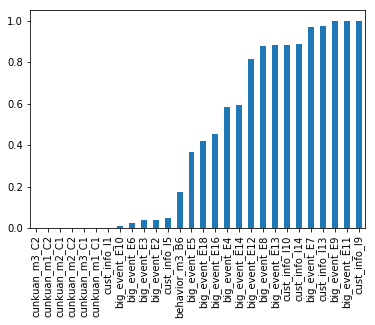

In [ ]:
# nan可视化
def seeWhichColumnsHaveMissingValues(data_train): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
seeWhichColumnsHaveMissingValues(df3_noNullLabel)

From the above plot, we find that there are several columns contains very big proportion of null value. We'd better give up such columns. 

I suggest we delete the columns that only have 0-1 columns

### object type data columns

In [ ]:
numerical_fea = list(df3_noNullLabel.select_dtypes(exclude=['object']).columns)
object_fea = list(filter(lambda x: x not in numerical_fea,list(df3_noNullLabel.columns)))
# label = 'label'
# numerical_fea.remove(label)

In [ ]:
print(numerical_fea)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B7', 'big_event_E11', 'big_event_E15', 'big_event_E17', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I4', 'cust_info_I6', 'cust_info_I7', 'cust_info_I9', 'cust_info_I11', 'cust_info_I15', 'cust_info_I16', 'cust_info_I17', 'cust_info_I18', 'cust_info_I19', 'cust_info_I20']


In [ ]:
## let's see what values do object features have: 
for fea in numerical_fea:
    if fea == "cust_no":
        continue
    print(f"==============={fea}=========================")
    print(df3_noNullLabel[fea].nunique())
#     print(df3_noNullLabel[fea].value_counts())

===============aum_m1_X1=========================
2087
===============aum_m1_X2=========================
1025
===============aum_m1_X3=========================
58037
===============aum_m1_X4=========================
1694
===============aum_m1_X5=========================
4963
===============aum_m1_X6=========================
1444
===============aum_m1_X7=========================
6101
===============aum_m1_X8=========================
838
===============aum_m2_X1=========================
2128
===============aum_m2_X2=========================
1020
===============aum_m2_X3=========================
57772
===============aum_m2_X4=========================
1677
===============aum_m2_X5=========================
5157
===============aum_m2_X6=========================
1549
===============aum_m2_X7=========================
6193
===============aum_m2_X8=========================
875
===============aum_m3_X1=========================
2126
===============aum_m3_X2=========================
1041
==========

In [ ]:
# #每个数字特征得分布可视化
# f = pd.melt(df3_noNullLabel, value_vars=numerical_fea)
# g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
# g = g.map(sns.distplot, "value")

In [ ]:
def plotEachCol(data_train, features):
    for fea in features:
        plt.figure(figsize=(10, 4))
        sns.barplot(data_train[fea].value_counts(dropna=False),
                    data_train[fea].value_counts(dropna=False).keys())
        plt.show()
plotEachCol(df3_noNullLabel, numerical_fea
           )

In [ ]:
## 过滤类别较少的和较多的列
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
    
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(df3_noNullLabel,numerical_fea)

In [ ]:
numerical_serial_fea

['aum_m1_X1',
 'aum_m1_X2',
 'aum_m1_X3',
 'aum_m1_X4',
 'aum_m1_X5',
 'aum_m1_X6',
 'aum_m1_X7',
 'aum_m1_X8',
 'aum_m2_X1',
 'aum_m2_X2',
 'aum_m2_X3',
 'aum_m2_X4',
 'aum_m2_X5',
 'aum_m2_X6',
 'aum_m2_X7',
 'aum_m2_X8',
 'aum_m3_X1',
 'aum_m3_X2',
 'aum_m3_X3',
 'aum_m3_X4',
 'aum_m3_X5',
 'aum_m3_X6',
 'aum_m3_X7',
 'aum_m3_X8',
 'behavior_m1_B1',
 'behavior_m1_B2',
 'behavior_m1_B3',
 'behavior_m1_B4',
 'behavior_m1_B5',
 'behavior_m2_B1',
 'behavior_m2_B2',
 'behavior_m2_B3',
 'behavior_m2_B4',
 'behavior_m2_B5',
 'behavior_m3_B1',
 'behavior_m3_B2',
 'behavior_m3_B3',
 'behavior_m3_B4',
 'behavior_m3_B5',
 'behavior_m3_B7',
 'big_event_E15',
 'big_event_E17',
 'cunkuan_m1_C1',
 'cunkuan_m1_C2',
 'cunkuan_m2_C1',
 'cunkuan_m2_C2',
 'cunkuan_m3_C1',
 'cunkuan_m3_C2',
 'cust_info_I2',
 'cust_info_I11']

In [ ]:
numerical_noserial_fea

['big_event_E11',
 'cust_info_I4',
 'cust_info_I6',
 'cust_info_I7',
 'cust_info_I9',
 'cust_info_I15',
 'cust_info_I16',
 'cust_info_I17',
 'cust_info_I18',
 'cust_info_I19',
 'cust_info_I20']

### object type featues

In [ ]:
print(object_fea)

['cust_no', 'behavior_m3_B6', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E4', 'big_event_E5', 'big_event_E6', 'big_event_E7', 'big_event_E8', 'big_event_E9', 'big_event_E10', 'big_event_E12', 'big_event_E13', 'big_event_E14', 'big_event_E16', 'big_event_E18', 'cust_info_I1', 'cust_info_I3', 'cust_info_I5', 'cust_info_I8', 'cust_info_I10', 'cust_info_I12', 'cust_info_I13', 'cust_info_I14']


In [ ]:
## let's see what values do object features have: 
for fea in object_fea:
    if fea == "cust_no":
        continue
    print(f"==============={fea}=========================")
    print(df3_noNullLabel[fea].nunique())
    print(df3_noNullLabel[fea].value_counts())

===============behavior_m3_B6=========================
22105
2020-03-31 21:01:00    344
2020-03-21 23:53:00    334
2020-03-31 21:03:00    331
2020-03-31 21:02:00    310
2020-03-21 23:57:00    310
2020-03-21 23:58:00    298
2020-03-31 21:05:00    294
2020-03-21 23:59:00    293
2020-03-31 21:04:00    289
2020-03-21 23:56:00    273
2020-03-21 23:54:00    268
2020-03-21 23:52:00    260
2020-03-21 23:55:00    259
2020-03-30 19:07:00    206
2020-03-31 21:00:00    203
2020-03-30 19:08:00    196
2020-03-26 02:37:00    170
2020-03-30 04:25:00    166
2020-03-31 04:32:00    154
2020-03-28 02:39:00    150
2020-03-21 03:38:00    150
2020-03-30 04:22:00    147
2020-03-30 04:23:00    145
2020-03-30 04:17:00    138
2020-03-30 04:26:00    138
2020-03-30 04:19:00    137
2020-03-30 04:20:00    133
2020-03-27 05:22:00    131
2020-03-27 05:20:00    127
2020-03-21 03:39:00    127
                      ... 
2020-03-26 21:23:00      1
2020-03-14 08:42:00      1
2020-03-18 19:54:00      1
2020-03-29 10:00:00  

2020-01-21    259
2020-01-20    242
2020-01-22    234
2020-01-23    214
2020-01-16    205
2020-01-14    192
2020-01-02    178
2020-01-15    174
2020-01-13    171
2020-01-07    169
2020-03-31    163
2020-01-10    160
2020-01-17    153
2020-01-06    152
2020-01-19    141
2020-02-25    135
2019-12-30    134
2020-03-03    133
2020-03-11    130
2020-03-30    130
2020-01-08    128
2020-01-03    125
2020-03-10    124
2020-03-25    124
2020-02-26    118
2020-03-18    117
2020-02-28    116
2020-03-24    116
2020-01-09    115
2020-02-04    113
             ... 
2015-05-16      1
2014-12-03      1
2015-11-28      1
2016-01-21      1
2014-08-19      1
2017-04-15      1
2015-05-04      1
2016-01-19      1
2016-07-31      1
2016-04-04      1
2015-09-05      1
2015-08-25      1
2014-09-26      1
2016-07-16      1
2018-06-24      1
2016-12-18      1
2015-02-28      1
2017-08-20      1
2014-10-21      1
2016-06-18      1
2016-05-06      1
2015-04-11      1
2016-03-27      1
2015-07-25      1
2014-10-28

In [ ]:
# df3_noNullLabel["label"].nunique()

# (Recycle bin)

## Load preprocessed dataset

In [ ]:
data_train = pd.read_csv('preprocessedData/lagrangeInterpolated_train-1.csv')
data_test_a = pd.read_csv('preprocessedData/lagrangeInterpolated_test-1.csv')

In [ ]:
data_train_cp = data_train.copy()
data_test_a_cp = data_test_a.copy()

In [ ]:
# data_train.isnull().sum()

## See how many columns have null values

IndexError: ignored

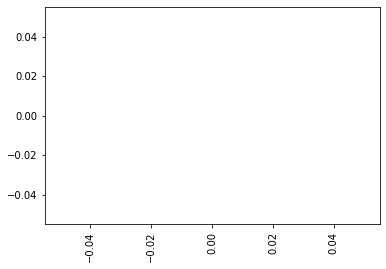

In [ ]:
# nan可视化
def seeWhichColumnsHaveMissingValues(data_train): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
seeWhichColumnsHaveMissingValues(data_train)

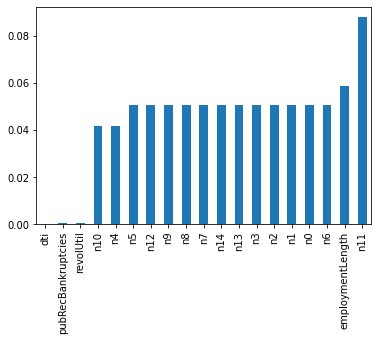

In [ ]:
seeWhichColumnsHaveMissingValues(data_test_a)

## Numerical features and category features

In [ ]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

In [ ]:
#过滤数值型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(data_train,numerical_fea)

In [ ]:
len(data_train.columns)

47

In [ ]:
len(numerical_serial_fea)

33

In [ ]:
len(numerical_noserial_fea)

8

In [ ]:
len(category_fea)

5

In [ ]:
label

'isDefault'

All in all, not columns are having too much null value.  

### See the `numerical_nonserial_fea` and get some value counts result

In [ ]:
for fea in numerical_noserial_fea:
    print("--------{}----------".format(fea))
    print(data_train[fea].value_counts())

--------term----------
3    606902
5    193098
Name: term, dtype: int64
--------homeOwnership----------
0    395732
1    317660
2     86309
3       185
5        81
4        33
Name: homeOwnership, dtype: int64
--------verificationStatus----------
1    309810
2    248968
0    241222
Name: verificationStatus, dtype: int64
--------initialListStatus----------
0    466438
1    333562
Name: initialListStatus, dtype: int64
--------applicationType----------
0    784586
1     15414
Name: applicationType, dtype: int64
--------policyCode----------
1.0    800000
Name: policyCode, dtype: int64
--------n11----------
0.0    729682
1.0       540
2.0        24
4.0         1
3.0         1
Name: n11, dtype: int64
--------n12----------
0.0    757315
1.0      2281
2.0       115
3.0        16
4.0         3
Name: n12, dtype: int64


**Mind this**: 
* No need to keep the `policyCode`.
* ~Let's try to delete the `n11` and `n12`? Seems that it is not very useful. The data is very biased.~
* We can make them one-hot. Or not. 

### See `category_fea`

In [ ]:
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [ ]:
for fea in category_fea:
    print("--------{}----------".format(fea))
    print(data_train[fea].value_counts())

--------grade----------
B    233690
C    227118
A    139661
D    119453
E     55661
F     19053
G      5364
Name: grade, dtype: int64
--------subGrade----------
C1    50763
B4    49516
B5    48965
B3    48600
C2    47068
C3    44751
C4    44272
B2    44227
B1    42382
C5    40264
A5    38045
A4    30928
D1    30538
D2    26528
A1    25909
D3    23410
A3    22655
A2    22124
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: subGrade, dtype: int64
--------employmentLength----------
10+ years    262753
2 years       72358
< 1 year      64237
3 years       64152
1 year        52489
5 years       50102
4 years       47985
6 years       37254
8 years       36192
7 years       35407
9 years       30272
Name: employmentLength, dtype: int64
--------issueDate----------
2016-03-01    29066
2015-10-01    25525
2015-07-01    24496
2015-12-01

We should encode these into numbers. 

### See the distribution of `numerical_serial_fea`

We can learn that all of the numerical serial features are above zero. 

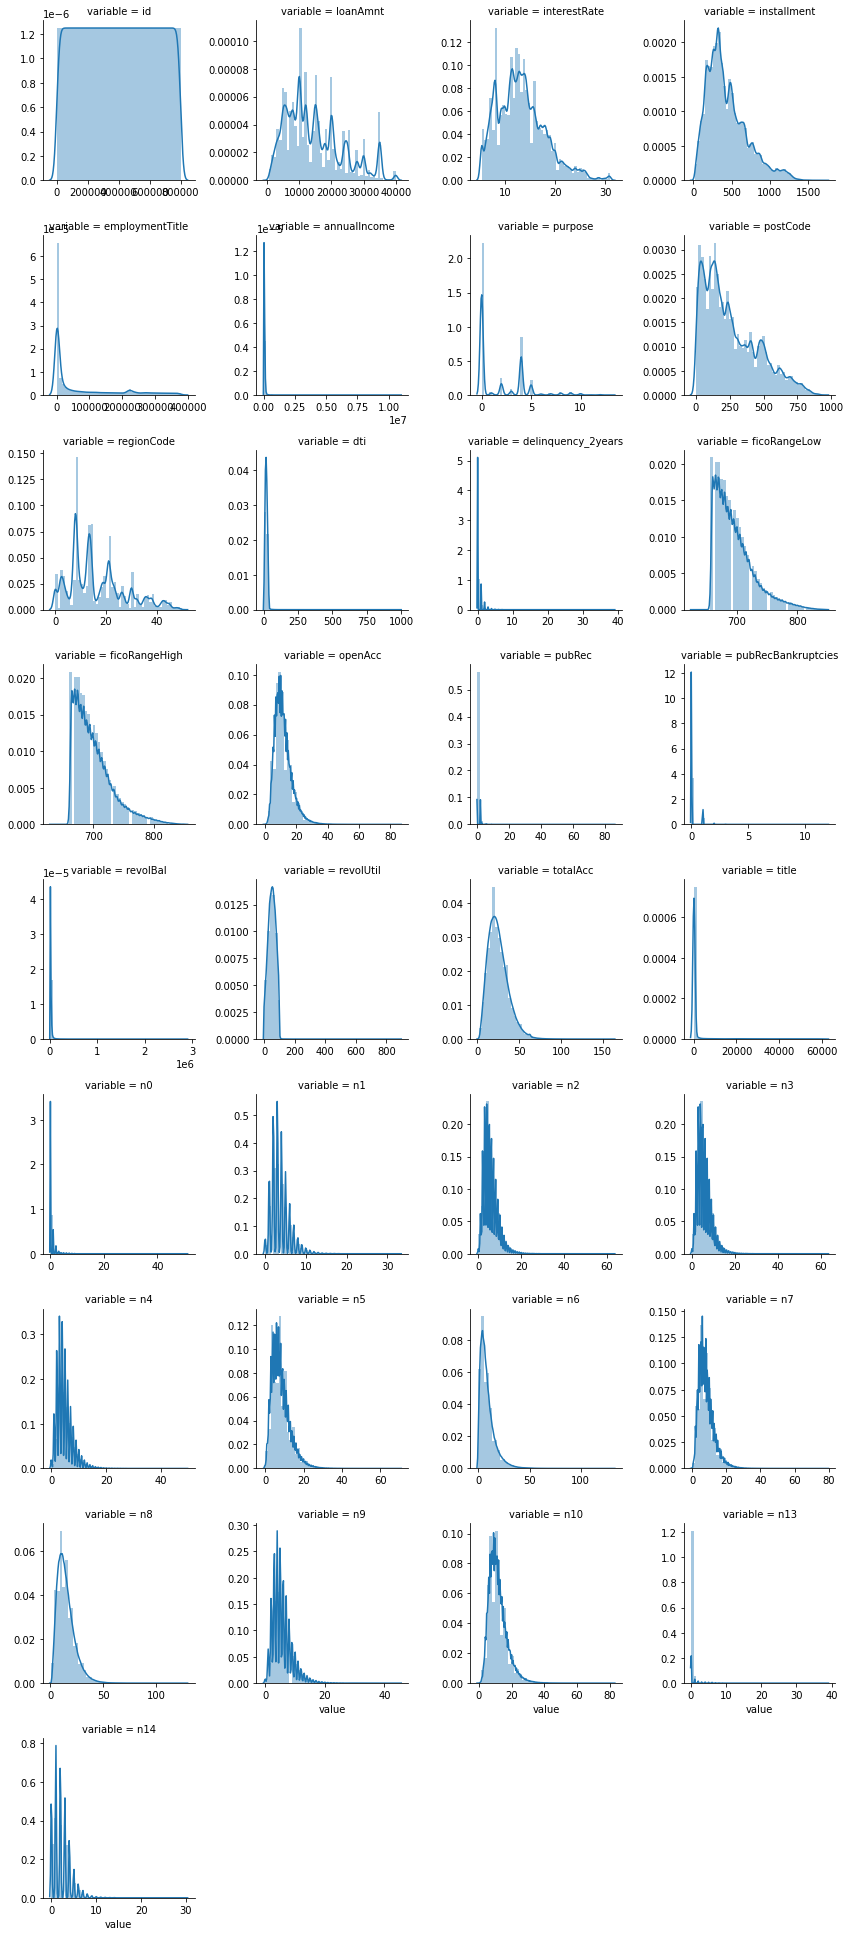

In [ ]:
#每个数字特征得分布可视化
f = pd.melt(data_train, value_vars=numerical_serial_fea)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

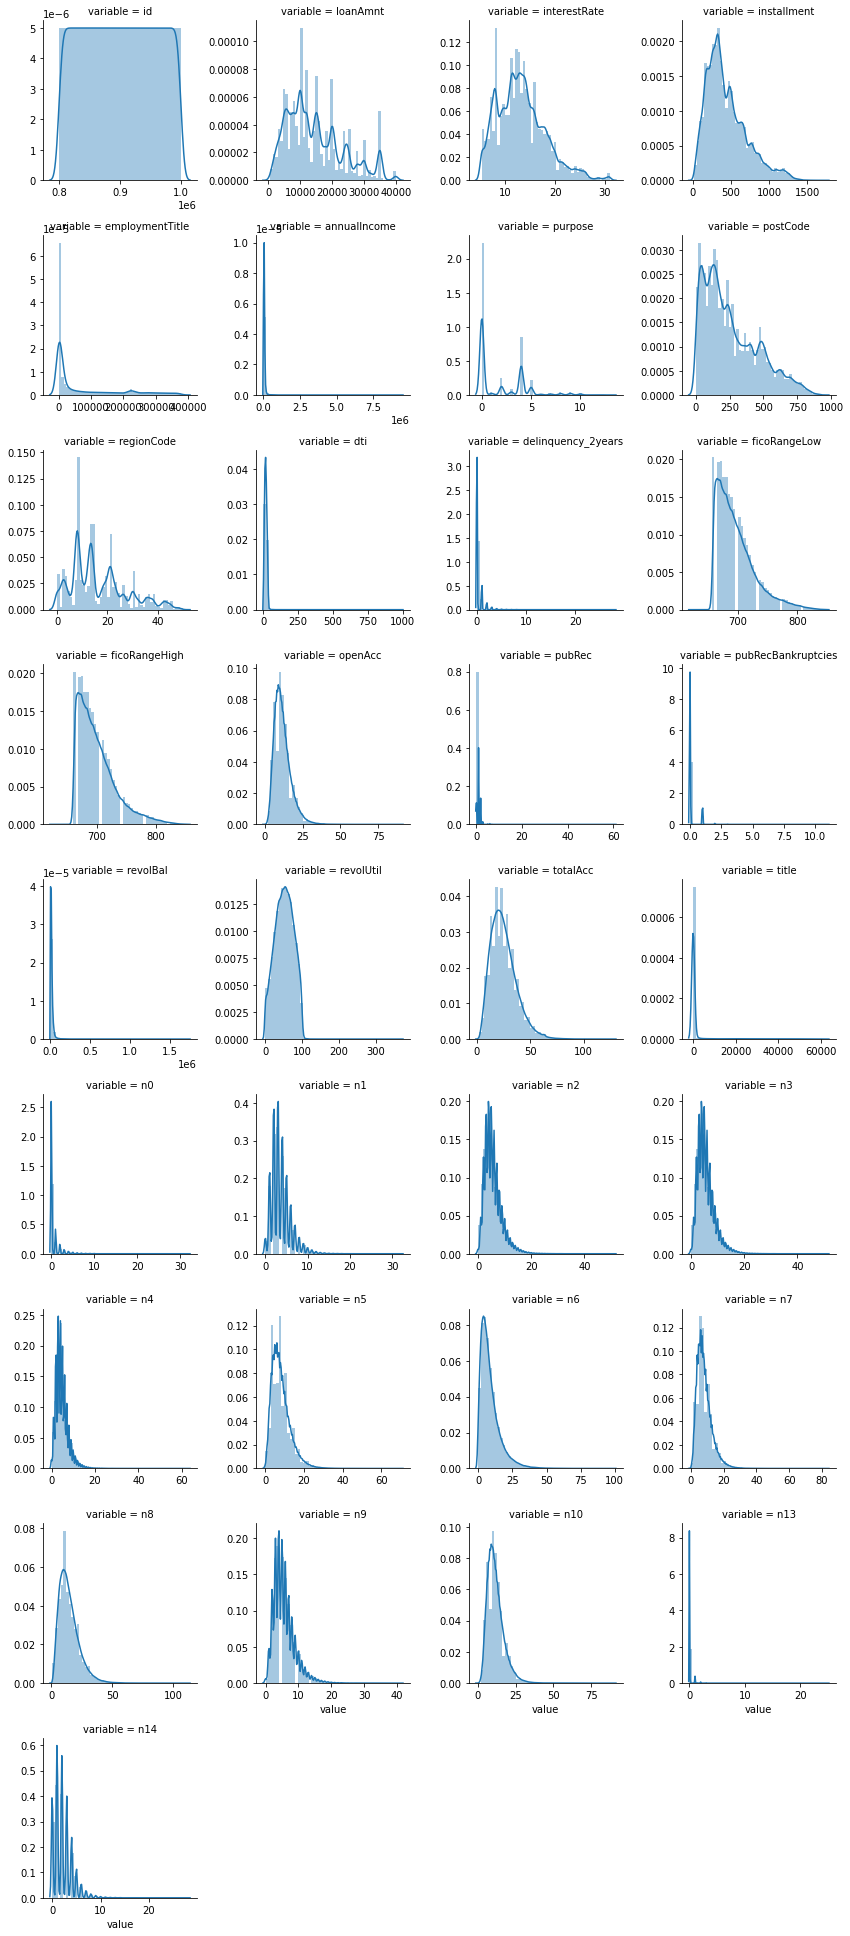

In [ ]:
#每个数字特征得分布可视化
f1 = pd.melt(data_test_a, value_vars=numerical_serial_fea)
g1 = sns.FacetGrid(f1, col="variable",  col_wrap=4, sharex=False, sharey=False)
g1 = g1.map(sns.distplot, "value")

If we log the `numerical_seriel_fea`: 

In [ ]:
# data_train_log = np.log(data_train)
# data_test_a_log = np.log(data_test_a)

data_train_cp = data_train.copy()
data_test_a_cp = data_test_a.copy()

for data in [data_train_cp, data_test_a_cp]:
    for fea in numerical_serial_fea:
        if fea in ["id"]:
            continue
        data[fea] = np.log1p(np.log1p(data[fea]))

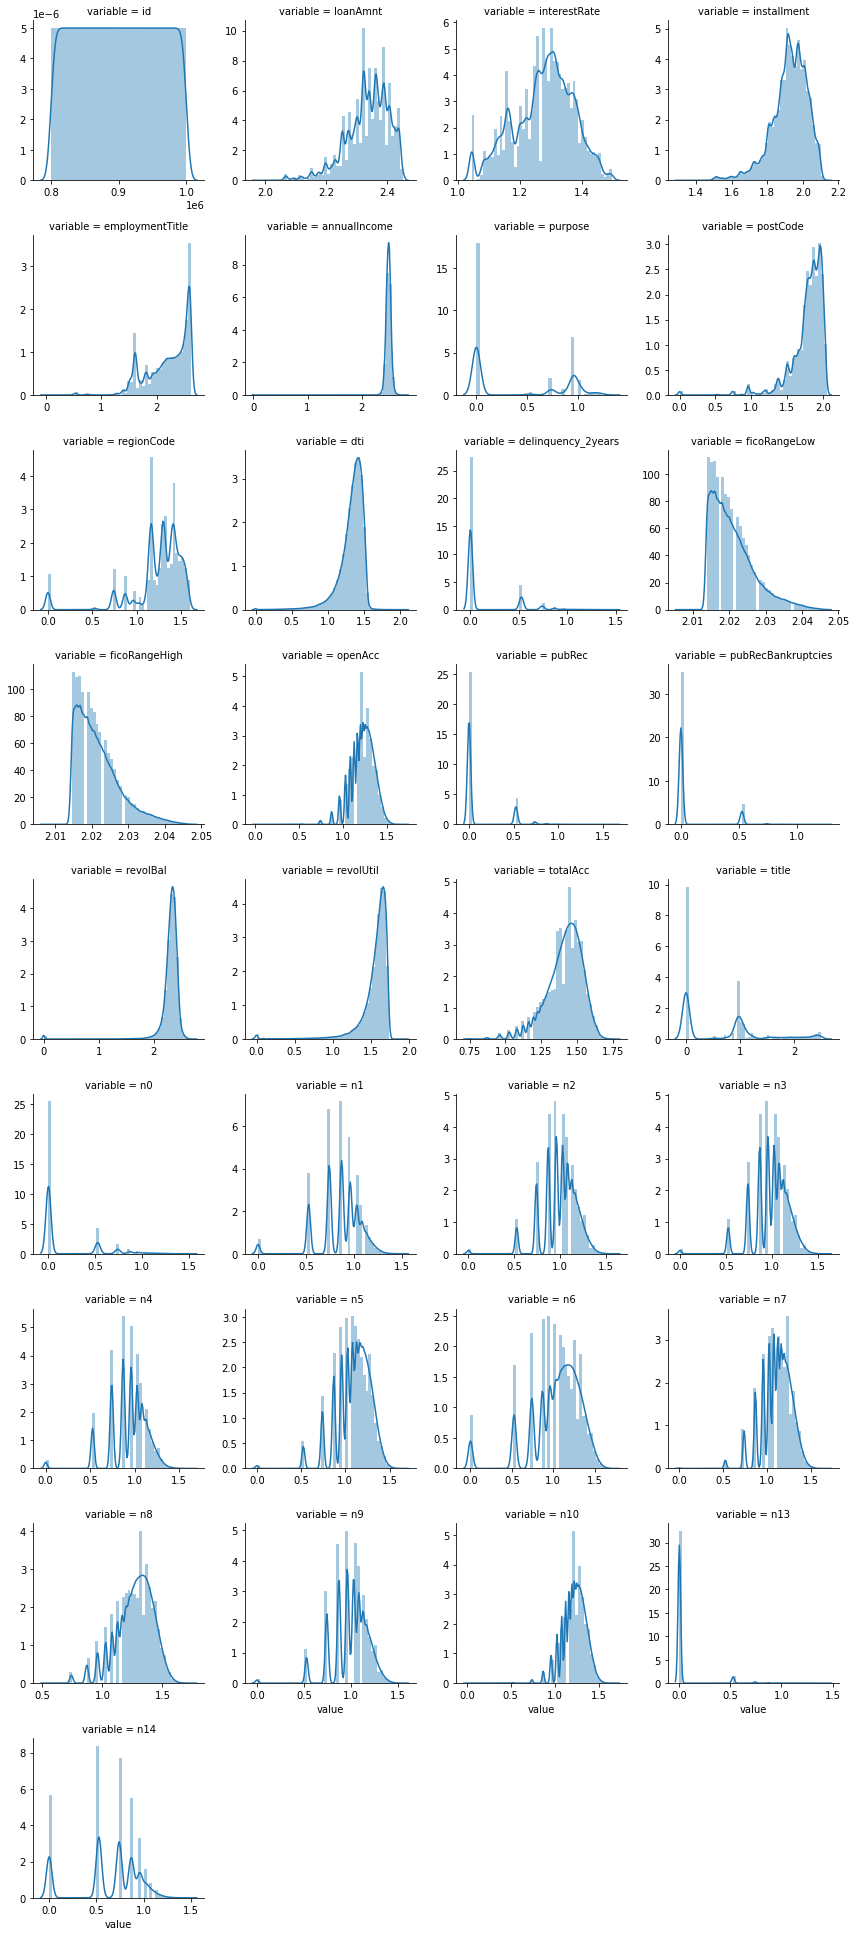

In [ ]:
# 二阶log1p
f1 = pd.melt(data_test_a_cp, value_vars=numerical_serial_fea)
g1 = sns.FacetGrid(f1, col="variable",  col_wrap=4, sharex=False, sharey=False)
g1 = g1.map(sns.distplot, "value")

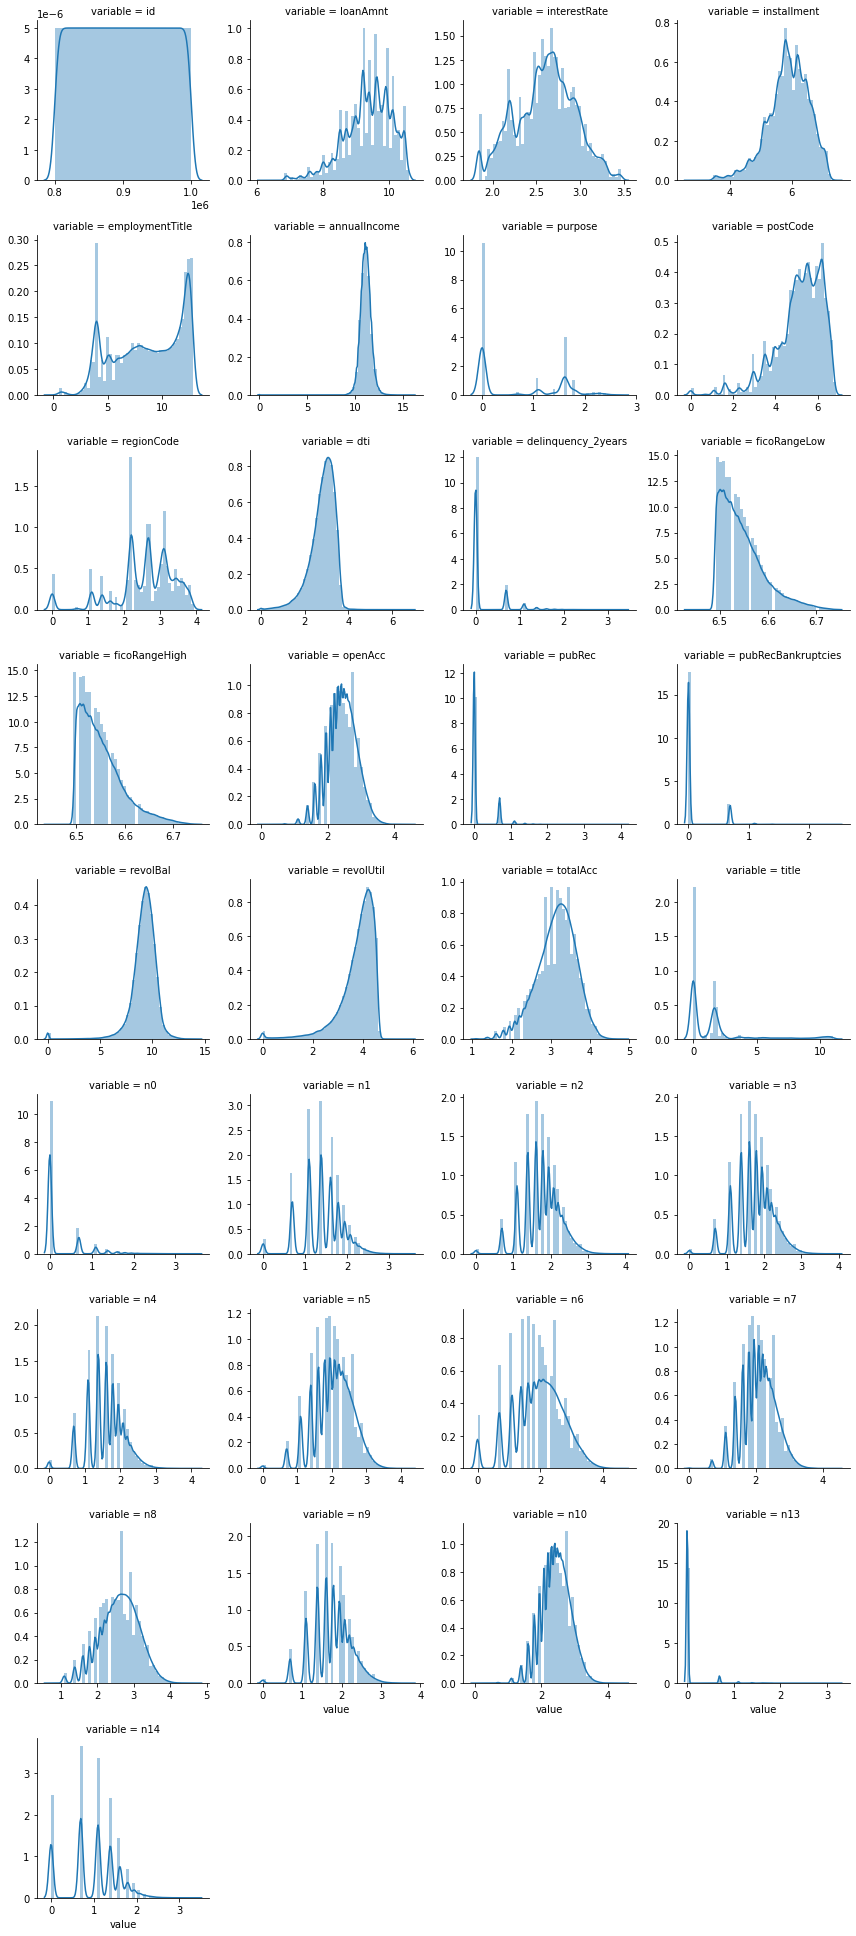

In [ ]:
#一阶log1p
f1 = pd.melt(data_test_a_cp, value_vars=numerical_serial_fea)
g1 = sns.FacetGrid(f1, col="variable",  col_wrap=4, sharex=False, sharey=False)
g1 = g1.map(sns.distplot, "value")

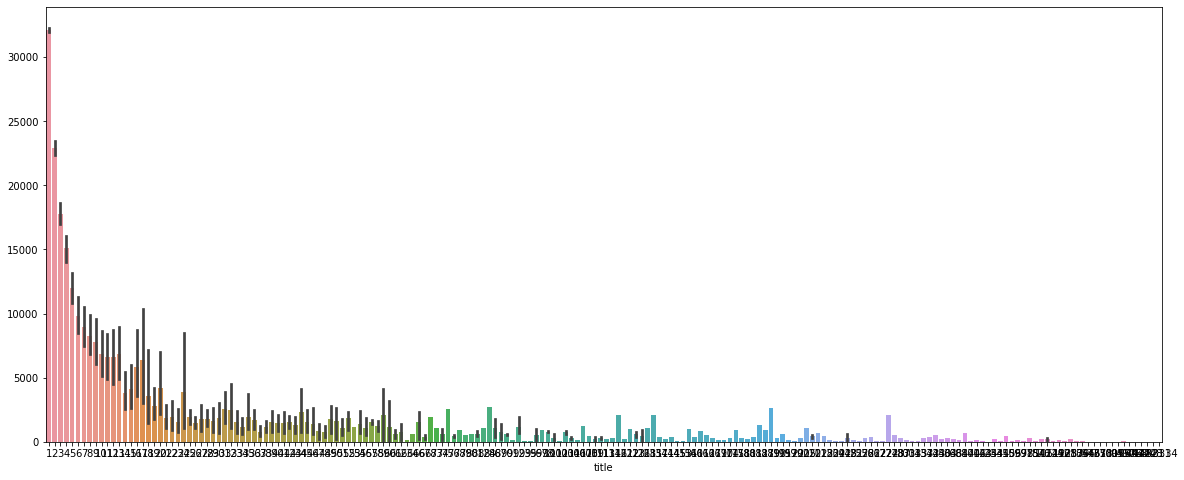

In [ ]:
# data_train_cp["title"].value_counts()
plt.figure(figsize=(20, 8))
sns.barplot(data_train["title"].value_counts(dropna=False),
            data_train["title"].value_counts(dropna=False).keys())
plt.show()

In [ ]:
# for fea in numerical_serial_fea: 
#     print("------{}-------".format(fea))
#     print(data_train[fea].value_counts().sort_index())

# data_train_cp.replace([np.inf, -np.inf], 0, inplace=True)
# data_test_a_cp.replace([np.inf, -np.inf], 0, inplace=True)